Get node labels

In [21]:
import sys
sys.path.append('..')
import data_utils
sys.path.append(data_utils.join_base_path('reallaborai4u/preprocessing'))
from feature_names import NON_CONDITIONAL_FEAT as LABELS
PRINT_LABELS = [l.removeprefix('EMA_') for l in LABELS]
from feature_names import INTERVENTION_NAMES_EN as EMI_LABELS

Settings

In [22]:
SAVE = True

VERSION = 'empirical covariance' #'Empirical Covariance'  # 'Pseudoinverse', 'Gaussian Obs Model'

### PLRNN

Calculate cumulative impulse responses for inputs targeted at single nodes

Version v3

In [9]:
import sys
sys.path.append('..')
import os
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
T = 7

os.makedirs('../results/_paper/network_perturbation_analyses', exist_ok=True)
errors_loading_model = 0
with PaperStyle(settings={'axes.grid':False}):

    plrnn_v3_cir = []
    
    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_cir = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir, only_valid_days=True)
        networks = []
        print(f'Perturbation analysis for MRT {mrt}....')
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = PLRNN()
            model.init_from_model_path(model_dir)
            try:
                Gamma, B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=VERSION)
            except:
                errors_loading_model += 1
                continue
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x, Gamma=Gamma, B=B).nanmean(0)
            # model_out_centrality = eval_reallabor_utils.weighted_degree_centrality(network, mode='out', absolute=False)
            # perturb_nodes = tc.arange(len(model_out_centrality))
            C = model.get_parameters()['C']
            
            model_cir = []
            x0 = tc.cat((tc.eye(x.shape[1]).float(), tc.zeros(x.shape[1]).float().unsqueeze(0)), 0)
            for i in range(C.shape[1]):
                perturbation = tc.zeros(C.shape[1]).float()
                perturbation[i] = 1
                subject_cir = eval_reallabor_utils.impulse_response(model, perturbation, T, cumulative=True, relative=True, x0=x0,
                                                                    Gamma=Gamma, B=B).mean(axis=0)
                model_cir.append(subject_cir)
            model_cir = tc.stack(model_cir, dim=0)
            mrt_cir.append(model_cir)

        mrt_cir = tc.stack(mrt_cir, dim=0)
        plrnn_v3_cir.append(mrt_cir)

# dims of mrt_cir: (mrt, subject, perturb_node, feature); dims of mrt_out_centrality: (mrt, subject, perturb_node)

Perturbation analysis for MRT 2....
Perturbation analysis for MRT 3....


Version x3-ensemble

In [40]:
import sys
sys.path.append('..')
import os
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from bptt.plrnn import PLRNN

MRT = [2, 3]
T = 7

os.makedirs('../results/_paper/network_perturbation_analyses', exist_ok=True)
errors_loading_model = 0
with PaperStyle(settings={'axes.grid':False}):

    plrnn_v3_ensemble_cir = []
    
    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_cir = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir, only_valid_days=False)
        networks = []
        print(f'Perturbation analysis for MRT {mrt}....')
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dirs = models.get_latest_model_dirs(p, timestep=1000)
            if len(model_dirs) == 0:
                continue
            ensemble_cir = []
            for model_dir in model_dirs:
                args = utils.load_args(model_dir)
                model = PLRNN()
                model.init_from_model_path(model_dir)
                try:
                    Gamma, B = eval_reallabor_utils.get_Gamma_and_B(model, model_dir, version=VERSION)
                except:
                    errors_loading_model += 1
                    continue
                x = tc.tensor(df[LABELS].to_numpy()).float()
                network = eval_reallabor_utils.get_network_matrix(model, x, Gamma=Gamma, B=B).nanmean(0)
                # model_out_centrality = eval_reallabor_utils.weighted_degree_centrality(network, mode='out', absolute=False)
                # perturb_nodes = tc.arange(len(model_out_centrality))
                C = model.get_parameters()['C']
                
                model_cir = []
                x0 = tc.cat((tc.eye(x.shape[1]).float(), tc.zeros(x.shape[1]).float().unsqueeze(0)), 0)
                for i in range(C.shape[1]):
                    perturbation = tc.zeros(C.shape[1]).float()
                    perturbation[i] = 1
                    subject_cir = eval_reallabor_utils.impulse_response(model, perturbation, T, cumulative=True, relative=True, x0=x0,
                                                                        Gamma=Gamma, B=B).mean(axis=0)
                    model_cir.append(subject_cir)
                model_cir = tc.stack(model_cir, dim=0)
                ensemble_cir.append(model_cir)
            if len(ensemble_cir) == 0:
                continue
            ensemble_cir = tc.stack(ensemble_cir, dim=0).mean(0)
            mrt_cir.append(ensemble_cir)

        mrt_cir = tc.stack(mrt_cir, dim=0)
        plrnn_v3_ensemble_cir.append(mrt_cir)

# dims of mrt_cir: (mrt, subject, perturb_node, feature); dims of mrt_out_centrality: (mrt, subject, perturb_node)

Perturbation analysis for MRT 2....
Perturbation analysis for MRT 3....


Plot cumulative impulse response of each EMI

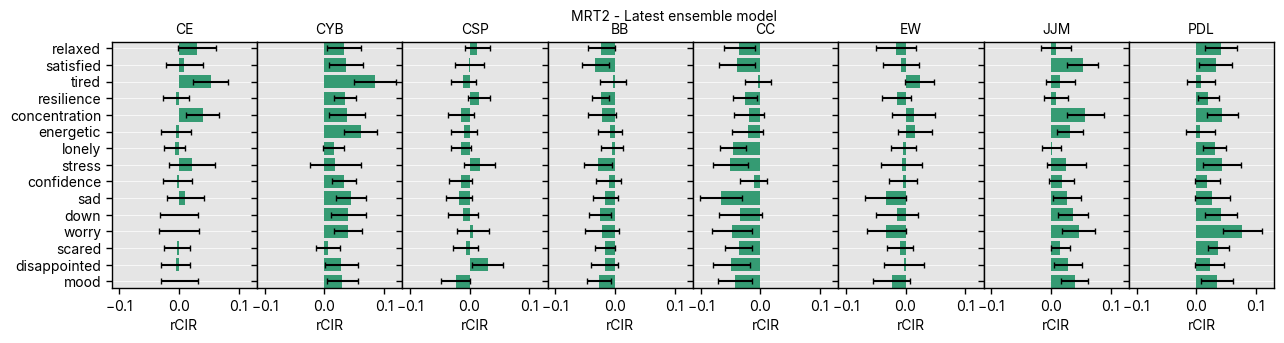

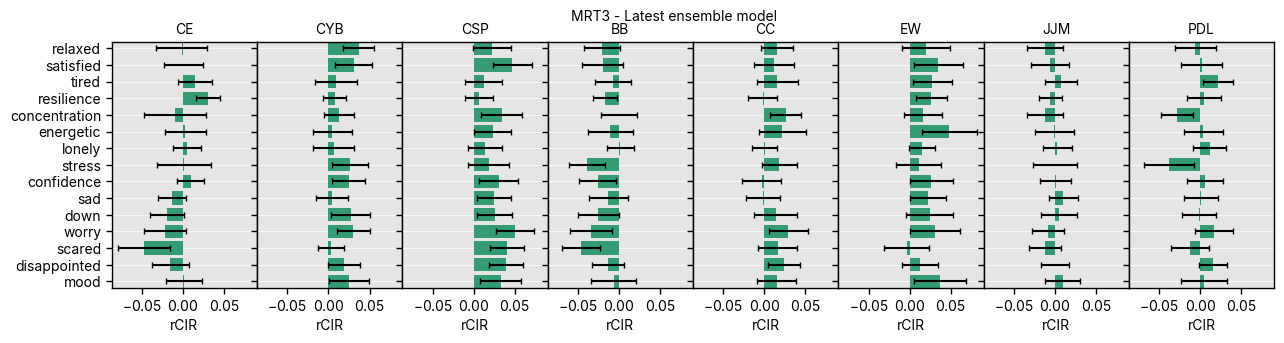

In [41]:
import math
from scipy import stats
import plotting_utils

EMI_short_labels = ['CE', 'CYB', 'CSP', 'BB', 'CC', 'EW', 'JJM', 'PDL']

with PaperStyle():

    for m, mrt in enumerate(MRT):
        fig, axes = plt.subplots(1, 8, figsize=(15, 3.2), sharey=True, sharex=True)
        # valid_map = ~cir[m].mean(2).isnan().any(1)
        z_cir = plrnn_v3_ensemble_cir[m]

        for i, (emi, ax) in enumerate(zip(range(z_cir.shape[1]), axes.flatten())):

            emi_cir = z_cir[:, emi]            
            ax.barh(tc.arange(z_cir.shape[2]), emi_cir.mean(0), xerr=stats.sem(emi_cir, axis=0), color='#359B73')
            ax.set_yticks(range(z_cir.shape[2]), labels=PRINT_LABELS)
            ax.set_title(EMI_short_labels[emi])
            ax.set(xlabel='rCIR')
            
        fig.suptitle(f'MRT{mrt} - Latest ensemble model')
        # fig.tight_layout()
        plt.subplots_adjust(wspace=0)
        if SAVE:
            fig.savefig(f'../results/_paper/network_perturbation_analyses/plrnn_cir_emi_mrt{mrt}_ensemble.svg')        
    plt.show()


### KalmanFilter

Calculate cumulative impulse responses for inputs targeted at single nodes

In [ ]:
import sys
sys.path.append('..')
import os
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import KalmanFilter

MRT = [2, 3]
T = 7

os.makedirs('../results/_paper/network_perturbation_analyses', exist_ok=True)
with PaperStyle(settings={'axes.grid':False}):

    kalman_cir = []
    
    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v2_MRT{mrt}_Kalman_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_cir = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        networks = []
        print(f'Perturbation analysis for MRT {mrt}....')
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = KalmanFilter(args)
            model.init_from_model_path(model_dir)
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
            B, C = model.params['B'], model.params['C']
            
            model_cir = []
            # x0 = tc.cat((tc.eye(x.shape[1]).float(), tc.zeros(x.shape[1]).float().unsqueeze(0)), 0)
            for i in range(C.shape[1]):
                perturbation = tc.zeros(C.shape[1]).float()
                perturbation[i] = 1
                subject_cir = eval_reallabor_utils.impulse_response(model, perturbation, T, cumulative=True, relative=True)
                model_cir.append(subject_cir)
            model_cir = tc.stack(model_cir, dim=0)
            mrt_cir.append(model_cir)

        mrt_cir = tc.stack(mrt_cir, dim=0)
        kalman_cir.append(mrt_cir)

# dims of mrt_cir: (mrt, subject, perturb_node, feature); dims of mrt_out_centrality: (mrt, subject, perturb_node)

Perturbation analysis for MRT 2....
Perturbation analysis for MRT 3....


In [ ]:
import sys
sys.path.append('..')
import os
import torch as tc
import matplotlib.pyplot as plt
import eval_reallabor_utils
import data_utils
import utils
from plotting_styles import PaperStyle
from comparison_models.simple_models.models import KalmanFilter

MRT = [2, 3]
T = 7

os.makedirs('../results/_paper/network_perturbation_analyses', exist_ok=True)
with PaperStyle(settings={'axes.grid':False}):

    kalman_v3_cir = []
    
    for mrt in MRT:

        results_dir = data_utils.join_ordinal_bptt_path('results', f'v3_MRT{mrt}_Kalman_every_day')
        test_data_dir = data_utils.dataset_path(mrt, 'processed_csv_no_con')
        mrt_cir = []

        print(f'Collecting models for MRT {mrt}....')
        models = eval_reallabor_utils.ModelCatalogue(results_dir)
        networks = []
        print(f'Perturbation analysis for MRT {mrt}....')
        for p, df in data_utils.zip_participants_data(test_data_dir):
            model_dir = models.get_best_latest_model_dir(p, timestep=1000)
            if model_dir is None:
                continue
            args = utils.load_args(model_dir)
            model = KalmanFilter(args)
            model.init_from_model_path(model_dir)
            x = tc.tensor(df[LABELS].to_numpy()).float()
            network = eval_reallabor_utils.get_network_matrix(model, x).nanmean(0)
            B, C = model.params['B'], model.params['C']
            
            model_cir = []
            # x0 = tc.cat((tc.eye(x.shape[1]).float(), tc.zeros(x.shape[1]).float().unsqueeze(0)), 0)
            for i in range(C.shape[1]):
                perturbation = tc.zeros(C.shape[1]).float()
                perturbation[i] = 1
                subject_cir = eval_reallabor_utils.impulse_response(model, perturbation, T, cumulative=True, relative=True)
                model_cir.append(subject_cir)
            model_cir = tc.stack(model_cir, dim=0)
            mrt_cir.append(model_cir)

        mrt_cir = tc.stack(mrt_cir, dim=0)
        kalman_v3_cir.append(mrt_cir)

# dims of mrt_cir: (mrt, subject, perturb_node, feature); dims of mrt_out_centrality: (mrt, subject, perturb_node)

Perturbation analysis for MRT 2....
Perturbation analysis for MRT 3....


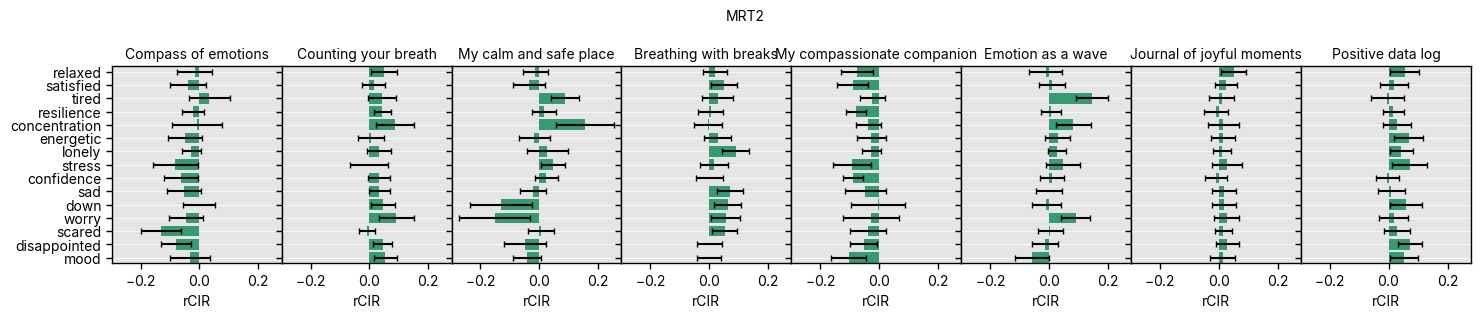

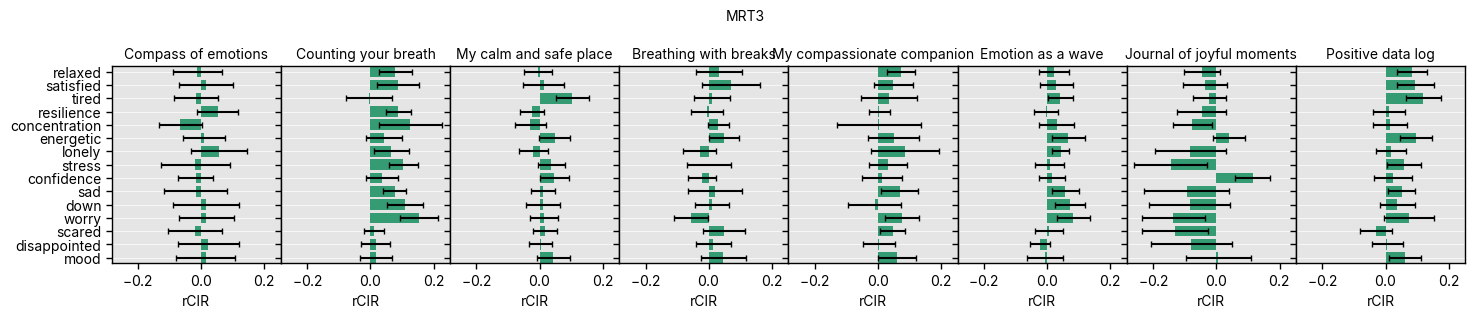

In [ ]:
import math
from scipy import stats
import plotting_utils

cir = kalman_v3_cir

with PaperStyle():

    for m, mrt in enumerate(MRT):
        fig, axes = plt.subplots(1, 8, figsize=(15, 3.2), sharey=True, sharex=True)
        # valid_map = ~cir[m].mean(2).isnan().any(1)
        z_cir = cir[m]

        for i, (emi, ax) in enumerate(zip(range(z_cir.shape[1]), axes.flatten())):

            emi_cir = z_cir[:, emi]            
            ax.barh(tc.arange(z_cir.shape[2]), emi_cir.mean(0), xerr=stats.sem(emi_cir, axis=0), color='#359B73')
            ax.set_yticks(range(z_cir.shape[2]), labels=PRINT_LABELS)
            ax.set(title=EMI_LABELS[emi], xlabel='rCIR')
            
        fig.suptitle(f'MRT{mrt}')
        fig.tight_layout()
        plt.subplots_adjust(wspace=0)
        if SAVE:
            fig.savefig(f'../results/_paper/network_perturbation_analyses/kalman_cir_emi_mrt{mrt}_v3.svg')        
    plt.show()
